In [2]:
from dotenv import load_dotenv
load_dotenv()

import os

import numpy as np
from pixell import enmap, enplot, reproject
import glob
import matplotlib.pyplot as plt
import emcee, corner
from astropy.io import fits
import sys
from astropy import units as u, constants as const
sys.path.insert(0, '../src')
import sys
import warnings
import os
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import yaml
import itertools
from pixell import enmap

import bandpass as bp
import covariance as cov
import model
import utils as ut

import SZpack as SZ

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def coadd_act(nways, dire, ref_wcs, region, plot_coadd=True, use_srcfree_maps=True):
    """
    Makes a coadded map of ACT data.
    nways: number of splits [int]
    dire: directory [str]
    wcs_ref: reference file for wcs [str]
    """
    freqs = ['*098*', '*150*', '*220*']
    arrays = ['*pa4*', '*pa5*', '*pa6*']

    if use_srcfree_maps:
        data_str = "_srcfree"
    else:
        data_str = ""

    for freq in freqs:
        for array in arrays:
            test_name = dire+array+freq+"*set0*map*fits*"
            exist_check = glob.glob(test_name)
            print(test_name, exist_check)
            if len(exist_check) == 0: 
                continue
            
            if nways == 8:
                split0_str = np.sort(glob.glob(dire+array+freq+"*set0*map"+data_str+".fits*"))[0]
                split1_str = np.sort(glob.glob(dire+array+freq+"*set1*map"+data_str+".fits*"))[0]
                split2_str = np.sort(glob.glob(dire+array+freq+"*set2*map"+data_str+".fits*"))[0]
                split3_str = np.sort(glob.glob(dire+array+freq+"*set3*map"+data_str+".fits*"))[0]

                ivar0_str = np.sort(glob.glob(dire+array+freq+"*set0*ivar.fits*"))[0]
                ivar1_str = np.sort(glob.glob(dire+array+freq+"*set1*ivar.fits*"))[0]
                ivar2_str = np.sort(glob.glob(dire+array+freq+"*set2*ivar.fits*"))[0]
                ivar3_str = np.sort(glob.glob(dire+array+freq+"*set3*ivar.fits*"))[0]


                # Put ut.ut.imap_dim_check in front of enmap.read_fits
                # to check if the dimensions are the same

                split0 = ut.imap_dim_check(enmap.read_fits(split0_str))
                split1 = ut.imap_dim_check(enmap.read_fits(split1_str))
                split2 = ut.imap_dim_check(enmap.read_fits(split2_str))
                split3 = ut.imap_dim_check(enmap.read_fits(split3_str))

                ivar0 = ut.imap_dim_check(enmap.read_fits(ivar0_str))
                ivar1 = ut.imap_dim_check(enmap.read_fits(ivar1_str))
                ivar2 = ut.imap_dim_check(enmap.read_fits(ivar2_str))
                ivar3 = ut.imap_dim_check(enmap.read_fits(ivar3_str))
                                
                splits = np.array([split0, 
                                   split1,
                                   split2,
                                   split3])

                ivars = np.array([ivar0, 
                                  ivar1,
                                  ivar2,
                                  ivar3])

                coadd_sum = np.sum(splits * ivars, axis=0) / np.sum(ivars, axis=0)
                coadd_sum = enmap.ndmap(arr=coadd_sum, wcs=ref_wcs)
                
                fname_coadd = (dire+ "act_cut_cmb_" + '_' + array[1:4] 
                               + '_f' + freq[1:4] + f"_8way_coadd_map{data_str}.fits")
                
                print(fname_coadd)
                
                enmap.write_fits(fname_coadd, coadd_sum)
                
                if plot_coadd:
                    ut.plot_image(coadd_sum, title=freq + array, interval_type='percentile')
        
            elif nways == 4:
                # split0_str = np.sort(glob.glob(dire+array+freq+"*set0*map"+data_str+".fits*"))[0]
                # split1_str = np.sort(glob.glob(dire+array+freq+"*set1*map"+data_str+".fits*"))[0]
                # split2_str = np.sort(glob.glob(dire+array+freq+"*set2*map"+data_str+".fits*"))[0]
                # split3_str = np.sort(glob.glob(dire+array+freq+"*set3*map"+data_str+".fits*"))[0]
                
                # ivar0_str = np.sort(glob.glob(dire+array+freq+"*set0*ivar.fits*"))[0]
                # ivar1_str = np.sort(glob.glob(dire+array+freq+"*set1*ivar.fits*"))[0]
                # ivar2_str = np.sort(glob.glob(dire+array+freq+"*set2*ivar.fits*"))[0]
                # ivar3_str = np.sort(glob.glob(dire+array+freq+"*set3*ivar.fits*"))[0]

                # split0 = ut.imap_dim_check(enmap.read_fits(split0_str))
                # split1 = ut.imap_dim_check(enmap.read_fits(split1_str))
                # split2 = ut.imap_dim_check(enmap.read_fits(split2_str))
                # split3 = ut.imap_dim_check(enmap.read_fits(split3_str))

                # ivar0 = ut.imap_dim_check(enmap.read_fits(ivar0_str))
                # ivar1 = ut.imap_dim_check(enmap.read_fits(ivar1_str))
                # ivar2 = ut.imap_dim_check(enmap.read_fits(ivar2_str))
                # ivar3 = ut.imap_dim_check(enmap.read_fits(ivar3_str))

                split0_str = np.sort(glob.glob(dire+array+freq+"*set0*map"+data_str+".fits*"))[0]
                split1_str = np.sort(glob.glob(dire+array+freq+"*set1*map"+data_str+".fits*"))[0]
                split2_str = np.sort(glob.glob(dire+array+freq+"*set2*map"+data_str+".fits*"))[0]
                split3_str = np.sort(glob.glob(dire+array+freq+"*set3*map"+data_str+".fits*"))[0]
                
                ivar0_str = np.sort(glob.glob(dire+array+freq+"*set0*ivar.fits*"))[0]
                ivar1_str = np.sort(glob.glob(dire+array+freq+"*set1*ivar.fits*"))[0]
                ivar2_str = np.sort(glob.glob(dire+array+freq+"*set2*ivar.fits*"))[0]
                ivar3_str = np.sort(glob.glob(dire+array+freq+"*set3*ivar.fits*"))[0]

                split0 = ut.imap_dim_check(enmap.read_map(split0_str, box=region))
                split1 = ut.imap_dim_check(enmap.read_map(split1_str, box=region))
                split2 = ut.imap_dim_check(enmap.read_map(split2_str, box=region))
                split3 = ut.imap_dim_check(enmap.read_map(split3_str, box=region))

                ivar0 = ut.imap_dim_check(enmap.read_map(ivar0_str, box=region))
                ivar1 = ut.imap_dim_check(enmap.read_map(ivar1_str, box=region))
                ivar2 = ut.imap_dim_check(enmap.read_map(ivar2_str, box=region))
                ivar3 = ut.imap_dim_check(enmap.read_map(ivar3_str, box=region))
                
                splits = np.array([split0, 
                                   split1,
                                   split2,
                                   split3])

                ivars = np.array([ivar0, 
                                  ivar1,
                                  ivar2,
                                  ivar3])


                numerator = np.sum(splits * ivars, axis=0)
                deno      = np.sum(ivars, axis=0)

                print(numerator.shape, deno.shape)

                coadd_sum =  numerator / deno
                coadd_sum = enmap.ndmap(arr=coadd_sum, wcs=ref_wcs)
                
                fname_coadd = (dire + "new/region_new_act_cut_dr6v2_" + '_' + array[1:4] 
                               + '_f' + freq[1:4] + "_4way_coadd_map" + data_str + ".fits")
                print(fname_coadd)
                enmap.write_fits(fname_coadd, coadd_sum)
                
                if plot_coadd:
                    ut.plot_image(coadd_sum, title=freq + array, interval_type='percentile')
                
            else: 
                raise ValueError("Invalid number of ways/splits.")

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa4**098**set0*map*fits* []
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa5**098**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa5_f098_4way_set0_map_srcfree.fits']
(300, 300) (300, 300)
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa5_f098_4way_coadd_map_srcfree.fits


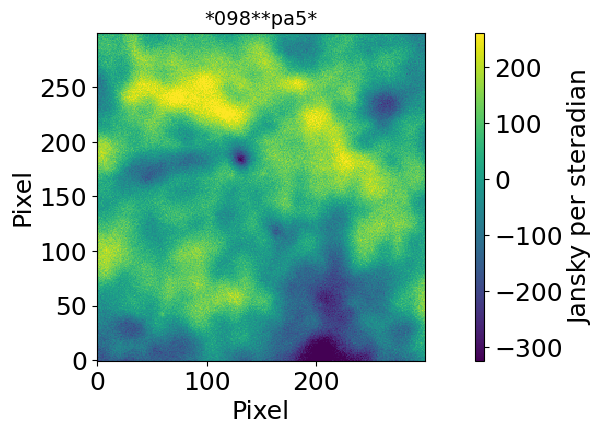

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa6**098**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa6_f098_4way_set0_map_srcfree.fits']
(300, 300) (300, 300)
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa6_f098_4way_coadd_map_srcfree.fits


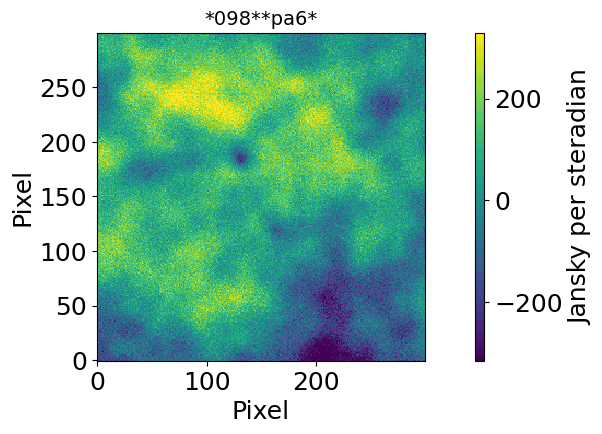

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa4**150**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa4_f150_4way_set0_map_srcfree.fits']
(300, 300) (300, 300)
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa4_f150_4way_coadd_map_srcfree.fits


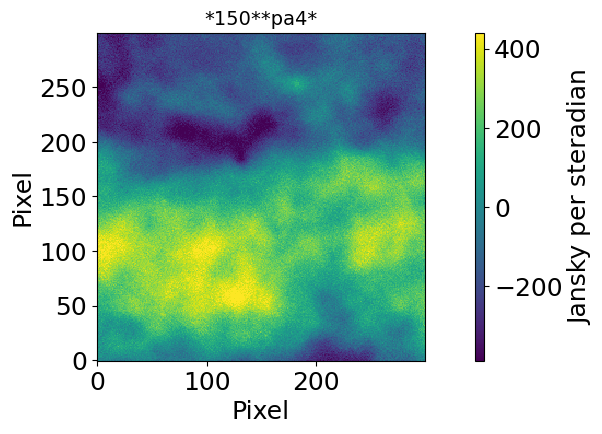

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa5**150**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa5_f150_4way_set0_map_srcfree.fits']
(300, 300) (300, 300)
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa5_f150_4way_coadd_map_srcfree.fits


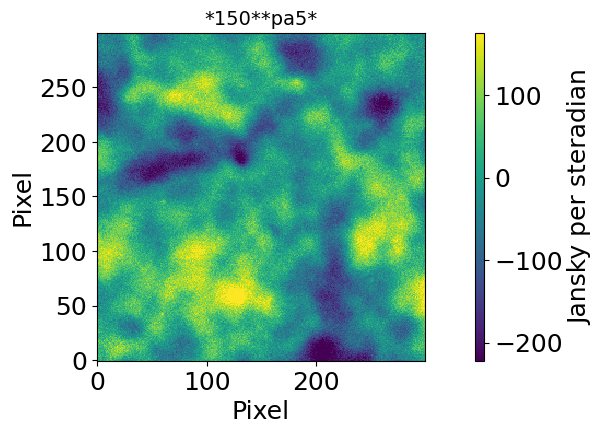

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa6**150**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa6_f150_4way_set0_map_srcfree.fits']
(300, 300) (300, 300)
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa6_f150_4way_coadd_map_srcfree.fits


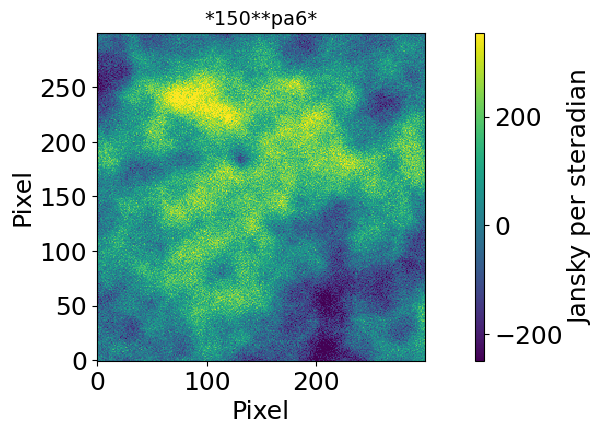

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa4**220**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa4_f220_4way_set0_map_srcfree.fits']
(300, 300) (300, 300)
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa4_f220_4way_coadd_map_srcfree.fits


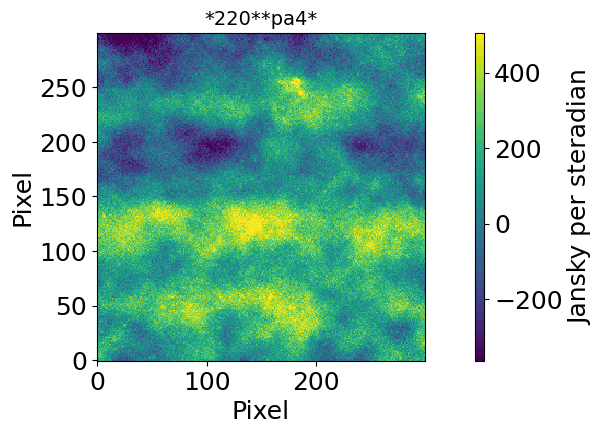

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa5**220**set0*map*fits* []
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa6**220**set0*map*fits* []


In [28]:
config_data = ut.get_config_file("../configs/config_mcmc.yaml")

cluster_region = ut.get_region(region_center_ra=config_data['region_center_ra'], 
                               region_center_dec=config_data['region_center_dec'],
                               region_width=config_data['region_width'])

dire = "/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/"
data = enmap.read_map(dire + "/act_cut_dr6v2_pa6_f150_4way_coadd_map_srcfree.fits", box=cluster_region)
nways = 4

coadd_act(nways=nways, dire=dire, ref_wcs=data.wcs,
           plot_coadd=True, use_srcfree_maps=True, region=cluster_region)

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa4**098**set0*map*fits* []
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa5**098**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa5_f098_4way_set0_map_srcfree.fits']
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa5_f098_4way_coadd_map_srcfree.fits


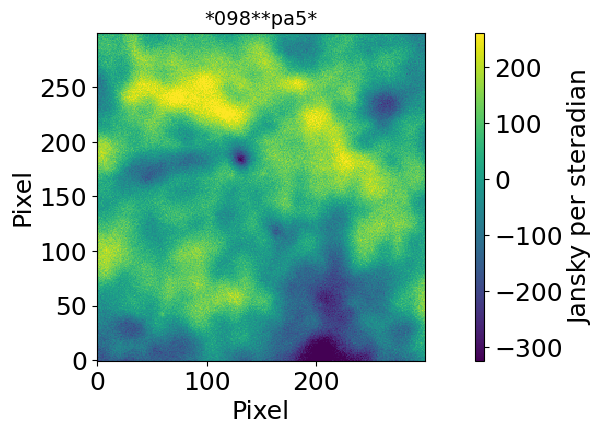

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa6**098**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa6_f098_4way_set0_map_srcfree.fits']
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa6_f098_4way_coadd_map_srcfree.fits


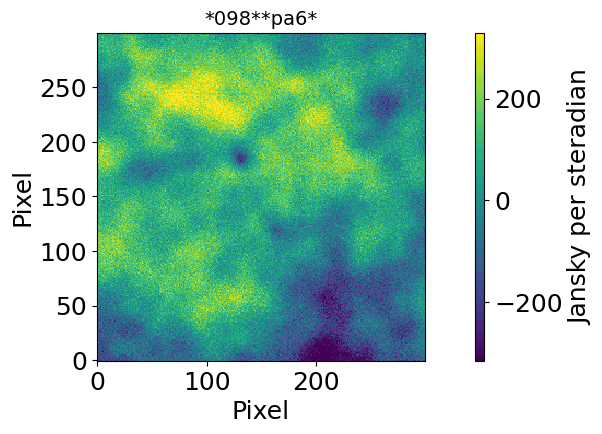

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa4**150**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa4_f150_4way_set0_map_srcfree.fits']
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa4_f150_4way_coadd_map_srcfree.fits


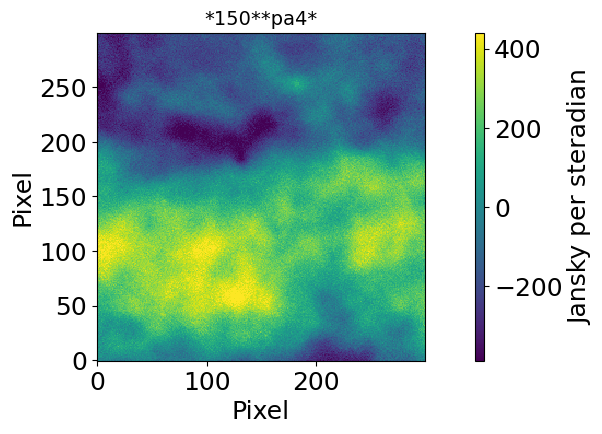

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa5**150**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa5_f150_4way_set0_map_srcfree.fits']
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa5_f150_4way_coadd_map_srcfree.fits


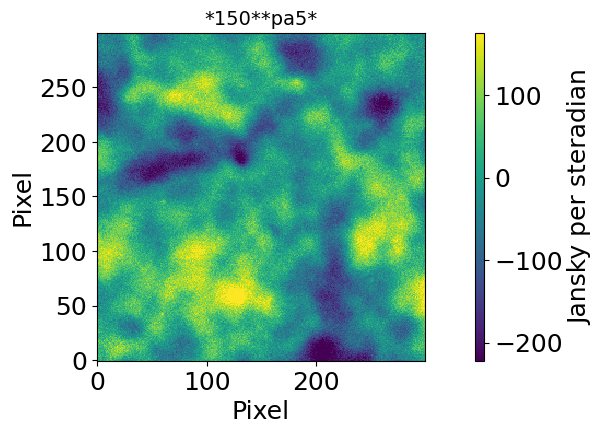

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa6**150**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa6_f150_4way_set0_map_srcfree.fits']
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa6_f150_4way_coadd_map_srcfree.fits


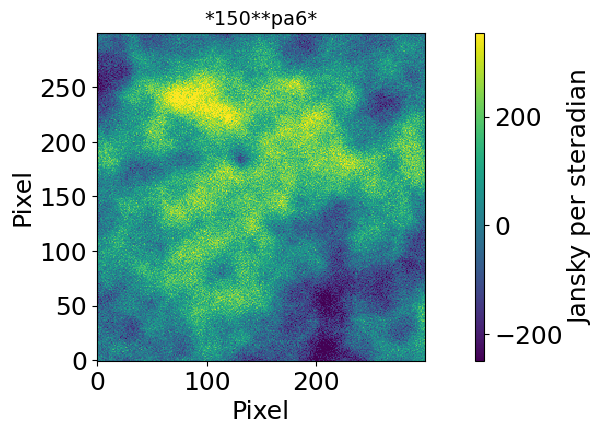

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa4**220**set0*map*fits* ['/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa4_f220_4way_set0_map_srcfree.fits']
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/new/region_new_act_cut_dr6v2__pa4_f220_4way_coadd_map_srcfree.fits


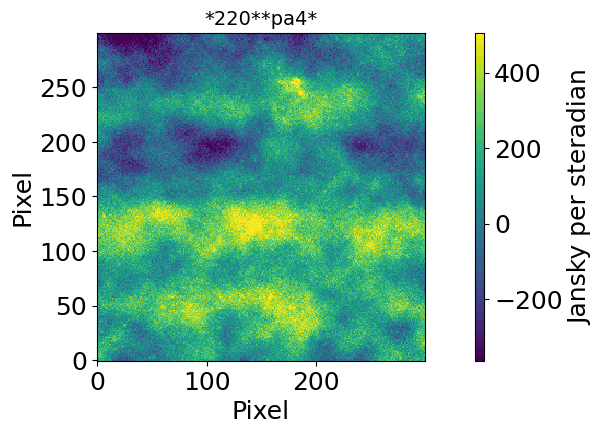

/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa5**220**set0*map*fits* []
/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/*pa6**220**set0*map*fits* []


In [24]:
coadd_act(nways=nways, dire=dire, 
          ref_wcs=data.wcs, 
          plot_coadd=True, 
          use_srcfree_maps=True, region=cluster_region)